# Lab on Stochastic Linear Bandits

**By: Kevin Alexandro Sanchez Diaz & Yevhenii Sielskyi**

We provide the environment to run a standard linear bandit experiment. The objective of this lab session is to understand how to implement `LinUCB`, the algorithm seen in class and its variant `LinTS`. We shall see that in practice there are some shortcomings in the implementation to make it efficient so we will guide you to obtain a working version.

Questions are inline in the notebook and some reserved space are allocated for answers, but feel free to add cells for remarks and run your own experiments to test hypotheses you may have. 

In [3]:
import numpy as np
from model import Environment, Agent
from display import plot_regret

from scipy.stats import bernoulli
from math import log

import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Action generators 

In [4]:
def randomActionsGenerator(K, d):
    """
    K: int -- number of action vectors to be generated
    d: int -- dimension of the action space
    returns: an array of K vectors uniformly sampled on the unit sphere in R^d
    """

    vecs = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=K)
    norms = np.linalg.norm(vecs, axis=1)
    return vecs / norms[:, np.newaxis]

In [5]:
a = randomActionsGenerator(100, 2)

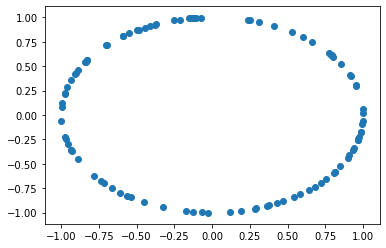

In [6]:
plt.scatter(a[:, 0], a[:, 1])
plt.show()

# Environment Class

In [7]:
class LinearBandit(Environment):
    def __init__(self, theta, K, model='gaussian', var=1.):
        """
        theta: d-dimensional vector (bounded) representing the hidden parameter
        K: number of actions per round (random action vectors generated each time)
        """
        self.model = model
        self.d = np.size(theta)
        self.theta = theta
        self.K = K
        self.var = var
        self.current_action_set = np.zeros(self.d)
        
    def get_action_set(self):
        self.current_action_set = randomActionsGenerator(self.K, self.d)
        return self.current_action_set
        
    def get_reward(self, action):
        """ sample reward given action and the model of this bandit environment
        action: d-dimensional vector (action chosen by the learner)
        """
        mean = np.dot(action, self.theta)
        if self.model == 'gaussian':
            return np.random.normal(mean, scale=self.var)
        else:#add bernoulli model option
            raise NotImplementedError('only Gaussian rewards are implemented so far')
            
    def get_means(self):
        return np.dot(self.current_action_set, self.theta)

# Linear Bandit Agents


## LinUCB : Implementing optimism in $R^d$

As seen in class, the actions are now vectors in $R^d$, representing contextual features, and the environment is assumed to generate rewards according to some hidden linear function $f_\theta(a) = a^\top \theta$. The goal of the learner is thus to estimate $\theta$ while keeping a measure of the uncertainty in all the directions of the feature space. 

* Baselines: First implement a `LinUniform` Agent that returns one of the action vectors of the action set, chosen uniformly at random. Then, implement a `LinEpsilonGreedy` agent as seen in the previous Lab. Do you think these agents can have a sublinear regret? Open question: Are they good baselines?

> `LinUniform` and `LinEpsilonGreedy` agents are implemented in the next 2 cells respectively.

> With a considerable number of simulations (*Monte Carlo* parameter `Nmc`) and a fairly distant finite horizon `T`, `LinUniform` agent can not be sublinear, since it makes its decisions completely randomly. In the case of `LinEpsilonGreedy` agent, it depends on the value of $\epsilon$: when $\epsilon = 1$, we obtain the same `LinUniform` agent; while decreasing $\epsilon,$ the regret of our agent becomes more and more sublinear since we will choose the next action, based on the $\hat{\theta}$ parameter (as a result of *R*egular *L*east *S*quares or *RLS*) with a higher probability.

> `LinUniform` (or `LinEpsilonGreedy` with $\epsilon = 1$) is a good baseline because it allows to explore the entire solution space and we can never perform worse than random. By the way, random predictions are frequently used as a baseline for various Machine Learning problems. `LinEpsilonGreedy` with $\epsilon < 1$ can also be used to compare with, where $\epsilon$ would tell us to what extent we should be no worse than random. E.g. `LinEpsilonGreedy` with $\epsilon = 0.5$ means that we need to perform at least as twice as better as a uniformly random choice.

* Implement `LinUCB` as studied in class: as for `LinUCB`, you need to compute UCBs for each arm of the current action set received from the environment, but this time the exploration bonus depends on the history of taken actions and received rewards. 

> `LinUCB` agent is implemented in the third cell below this one according to the formulas seen in class.

* One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. Remark however that at round $t+1$, the new covariance matrix is very similar to the previous one at round $t$... Can you think of a way to optimize this step by simply updating the old one? 
Hint: You can search for a way to compute the inverse of the sum of an invertible matrix A and the outer product, $ uv^\top$, of vectors u and v.

> Such an update can be done by means of the [Sherman–Morrison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula):

$$(A + u \cdot v^{\top})^{-1} = A^{-1} - \frac{A^{-1} \cdot u \cdot v^{\top} \cdot A^{-1}}{1 + v^{\top} \cdot A^{-1} \cdot u}, \tag{1}$$

where $A \in \mathbb{R}^{n \dot n}$ &mdash; invertible square matrix, $u, v$ are *n-*dimensional vectors ($u, v \in \mathbb{R}^{n}$). Obviously, we need to assure that $v^{\top} \cdot A^{-1} \cdot u \neq -1$.

> In our case, $V_i(\lambda)$ can be considered as $A$ and every time, when we are updating it with the previously chosen action $a_i$, ($a_i \sim u = v$), we can apply the given formula:

$$V_{i+1}^{-1} = (V_i + a_i \cdot a_i^{\top})^{-1} = V_i^{-1} - \frac{V_i^{-1} \cdot a_i \cdot a_i^{\top} \cdot V_i^{-1}}{1 + a_i^{\top} \cdot V_i^{-1} \cdot a_i}.$$

> The current trick is used for both `LinEpsilonGreedy` and `LinUCB` agents while computing *RLS*.

* It is common practice to modify `LinUCB` by multiplying the confidence bonus of each arm by some hyperparameter $ 0<\alpha <1$. 
What would be the effect of doing so? Do you think it is a good idea? What are the risks? 
Implement this little modification and compare the results for several values of $\alpha$ (see further down for experiments scripts).

> TODO

In [8]:
class LinUniform(Agent):
    def __init__(self):
        pass

    def get_action(self, arms):
        K, _ = arms.shape
        return arms[np.random.choice(K)]

    def receive_reward(self, chosen_arm, reward):
        pass

    def reset(self):
        pass

    #@staticmethod
    def name(self):
        return 'Unif'

In [9]:
class LinEpsilonGreedy(Agent):
    def __init__(self, T, d, epsilon, lambda_reg=1.):
        """
        Instantiate the agent using only the available information
        from the environment (i.e. not the means)
        
        Input:
        -------
            T: finite horizon, i. e. number of iterations, time limit;
            d: dimension of an action space;
            epsilon: probability to make a random decision;
            lambda_reg: regularization parameter,
                            initial value of the precision matrix V.
        """

        self.T = T
        self.d = d
        self.epsilon = epsilon
        self.lambda_reg = lambda_reg

        self.reset()

    def reset(self):
        """
        Reset all the local variables that should not be kept
        when the experiment is restarted

        Local variables:
        -------
            t: time counter;
            V_inv: inverse precision matrix V;
            b_n: previously cumulated rewards bias vector;
            hat_theta: estimated parameter vector.
        """

        self.t = 0
        self.V_inv = np.eye(self.d) / self.lambda_reg
        self.b_n = np.zeros([self.d, 1])
        self.hat_theta = np.zeros([self.d, 1])

    def get_action(self, arms):
        """
        This function implements LinEpsilonGreedy

        Input:
        -------
            arms: list of arms (d-dimensional vectors)

        Output:
        -------
            chosen_arm: pulled arm
        """

        # compute the UCB of each of the arm in arms, here arms are vectors:
        K, _ = arms.shape

        # implement epsilon-greedy:
        chosen_arm_index = 0
        if np.random.random() < self.epsilon:
            chosen_arm_index = np.random.randint(0, high=K)
        else:
            self.hat_theta = self.V_inv @ self.b_n

            UCBs = np.zeros(K)

            for i in range(K):
                a = np.expand_dims(arms[i], axis=1)
                
                UCBs[i] = a.T @ self.hat_theta
            chosen_arm_index = UCBs.argmax()

        self.t += 1

        chosen_arm = arms[chosen_arm_index]

        return chosen_arm
        
    def receive_reward(self, chosen_arm, reward):
        # Computing RLS:
        a = np.expand_dims(chosen_arm, axis=1)

        # Apply Sherman-Morrison formula:
        self.V_inv -= (self.V_inv @ a @ a.T @ self.V_inv) \
                        / (1 + a.T @ self.V_inv @ a)

        self.b_n += reward * a
        
    def name(self):
        return "LinEpsGreedy; $\epsilon$ = {:.1f}, $\lambda$ = {:.1f}".format(self.epsilon, self.lambda_reg)

In [10]:
class LinUCB(Agent):
    def __init__(self, T, d, delta, lambda_reg, alpha=None):
        """
        Instantiate the agent using only the available information
        from the environment (i.e. not the means)
        
        Input:
        -------
            T: finite horizon, i. e. number of iterations, time limit;
            d: dimension of an action space;
            delta: probability of theta being out of
                            the high-probability confidence region;
            lambda_reg: regularization parameter,
                            initial value of the precision matrix V;
            alpha: bonus multiplier.
        """

        self.T = T
        self.d = d
        self.delta = delta
        self.lambda_reg = lambda_reg
        self.alpha = alpha

        self.reset()

    def reset(self):
        """
        Reset all the local variables that should not be kept
        when the experiment is restarted

        Local variables:
        -------
            t: time counter;
            V_inv: inverse precision matrix V;
            b_n: previously cumulated rewards bias vector;
            hat_theta: estimated parameter vector.
        """

        self.t = 0
        self.V_inv = np.eye(self.d) / self.lambda_reg
        self.b_n = np.zeros([self.d, 1])
        self.hat_theta = np.zeros([self.d, 1])

    def get_action(self, arms):
        """
        This function implements LinUCB
        
        Input:
        -------
            arms: list of arms (d-dimensional vectors)

        Output:
        -------
            chosen_arm: pulled arm
        """

        # Compute the UCB of each of the arm in arms, here arms are vectors:
        K, _ = arms.shape
        UCBs = np.zeros(K)

        self.hat_theta = self.V_inv @ self.b_n

        beta_t = np.sqrt(self.lambda_reg) + np.sqrt(2 * np.log(1 / self.delta) \
                    + self.d * np.log((self.d * self.lambda_reg + self.t) / (self.lambda_reg * self.d)))
        if self.alpha is not None:
            beta_t *= self.alpha

        for i in range(K):
            a = np.expand_dims(arms[i], axis=1)
            
            UCBs[i] = a.T @ self.hat_theta + beta_t * np.sqrt(a.T @ self.V_inv @ a)
        chosen_arm = arms[UCBs.argmax()]

        self.t += 1

        return chosen_arm

    def receive_reward(self, chosen_arm, reward):
        # Computing RLS:
        a = np.expand_dims(chosen_arm, axis=1)

        # Apply Sherman-Morrison formula:
        self.V_inv -= (self.V_inv @ a @ a.T @ self.V_inv) \
                        / (1 + a.T @ self.V_inv @ a) 
        
        self.b_n += reward * a

    def name(self):
        name = "LinUCB; $\lambda$ = {:.1f}".format(self.lambda_reg)
        if self.alpha is not None:
            name += "; $\\alpha$ = " + str(self.alpha)

        return name

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian *samples* to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions. 

* Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\sigma_0 I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, can you compute the expression of the posterior at the beginning of round $t+1$?

> Let's denote $\pi_0(\theta) \sim \mathcal{N}(\mathbf{0}, \lambda Id)$ &mdash; prior $\theta$ distribution. Considering the reward equation: $Y_t = A_t^{\top} \cdot \theta + \eta_t$, let the reward noise $\eta_t \sim \mathcal{N}(\mathbf{0}, \sigma^2)$. Then, the likelihood conditional probability at the first step $p(Y_1 | A_1, \theta)$ would be also proportional to a Gaussian as a sum of two Gaussians:

$$p(Y_1| A_1, \theta) \propto \mathcal{N}(A_1^{\top} \cdot \theta, \sigma^2).$$

> Then, by Bayes' Theorem, the posterior probability $\pi_1(\theta; (A_1, Y_1))$ would be:

$$\pi_1(\theta; (A_1, Y_1)) = \frac{p(Y_1| A_1, \theta) \cdot \pi_0(\theta)}{\int p(Y_1| A_1, \theta) \cdot \pi_0(\theta) d\theta},$$

or, in proportions:

$$\pi_1(\theta; (A_1, Y_1)) \propto p(Y_1| A_1, \theta) \cdot \pi_0(\theta).$$

> Let's move to the logarithms to simplify the $e$s of the normal probabilities:

\begin{equation}
    ln(\pi_1(\theta; (A_1, Y_1))) \propto ln(p(Y_1 | A_1, \theta)) + ln(\pi_0(\theta) \\ = - \frac{1}{2 \sigma^2} ||A_1^{\top} \cdot \theta - Y_1||^2
 - \frac{1}{2} \theta^{\top} \cdot (\lambda Id)^{-1} \cdot \theta + const \\ = - \frac{1}{2 \sigma^2} \cdot (\theta^{\top} \cdot A_1 A_1^{\top} \cdot \theta - 2 Y_1^{\top} \cdot A_1^{\top} \cdot \theta + Y_1^{\top} Y_1) - \frac{1}{2} \theta^{\top} \cdot (\lambda \cdot Id)^{-1} \cdot \theta + const.
\end{equation}

> Rewriting $\mu_1 = \frac{1}{\sigma^2} \Sigma_1 \cdot A_1 \cdot Y_1$ and $\Sigma_1^{-1} = \frac{1}{\sigma^2} A_1 A_1^{\top} + (\lambda Id)^{-1}$, we obtain:

$$ln(\pi_1(\theta; (A_1, Y_1))) \propto - \frac{1}{2} (\theta - \mu_1)^{\top} \cdot \Sigma_1^{-1} \cdot (\theta - \mu_1) + const;$$

$$\pi_1(\theta; (A_1, Y_1)) \propto \mathcal{N}(\mu_1, \Sigma_1).$$

> Given $\Sigma_0^{-1} = (\lambda Id)^{-1}$, we can conclude by the *Mathematical Induction*, that:

$$\pi_0(\theta) \propto \mathcal{N}(\mathbf{0}, \Sigma_0)\ \&\ \pi_1(\theta; (A_1, Y_1)) \propto \mathcal{N}(\mu_1, \Sigma_1),$$

then

\begin{equation}
    \pi_t(\theta; (A_t, Y_t)) \propto \mathcal{N}(\mu_t, \Sigma_t)\mbox{, where } \Sigma_t^{-1} = \frac{1}{\sigma^2} \sum_{k = 1}^t A_k A_k^{\top} + (\lambda Id)^{-1}, \mu_t = \frac{1}{\sigma^2} \Sigma_t \cdot \sum_{k = 1}^t A_k \cdot Y_k \\ \Rightarrow \pi_{t + 1}(\theta; (A_{t + 1}, Y_{t + 1})) \propto \mathcal{N}(\mu_{t + 1}, \Sigma_{t + 1})\mbox{, where } \Sigma_{t + 1}^{-1} = \frac{1}{\sigma^2} \sum_{k = 1}^{t + 1} A_k A_k^{\top} + (\lambda Id)^{-1}, \mu_{t + 1} = \frac{1}{\sigma^2} \Sigma_{t + 1} \cdot \sum_{k = 1}^{t + 1} A_k \cdot Y_k.
\end{equation}

> But instead of calculating $\Sigma^{-1}$ at every iteration, we can store $\Sigma$ and apply *Sherman-Morrison* formula (formula *(1)*) to it (we will just need to handle an additional constant $\frac{1}{\sigma^2}$):

\begin{equation}
    (\Sigma^{-1} + \frac{A}{\sigma} \cdot \frac{A^{\top}}{\sigma})^{-1} = \Sigma - \frac{\Sigma \cdot \frac{A}{\sigma} \cdot \frac{A^{\top}}{\sigma} \cdot \Sigma}{1 + \frac{A^{\top}}{\sigma} \cdot \Sigma \cdot \frac{A}{\sigma}} = \Sigma - \frac{\frac{1}{\sigma^2} \Sigma \cdot A A^{\top} \cdot \Sigma}{\frac{1}{\sigma^2} (\sigma^2 + A^{\top} \cdot \Sigma \cdot A)} = \Sigma - \frac{\Sigma \cdot A A^{\top} \cdot \Sigma}{\sigma^2 + A^{\top} \cdot \Sigma \cdot A}.
\end{equation}

> The last approach was also implemented to optimize computations.
 
* Implement a `LinTS` (*Linear Thompson Sampling*) agent and run it against `LinUCB` and `LinUCB` with some $\alpha$ scaling parameter (see further down).

> `LinUCB` agent is implemented in the cell below.

In [11]:
class LinTS(Agent):
    def __init__(self, T, d, lambda_reg, sigma=.1):
        """
        Instantiate the agent using only the available information
        from the environment (i.e. not the means)
        
        Input:
        -------
            T: finite horizon, i. e. number of iterations, time limit;
            d: dimension of an action space;
            epsilon: probability to make a random decision;
            lambda_reg: regularization parameter,
                            initial value of the covariance matrix Sigma;
            sigma: standard deviation of the rewards.
        """

        self.T = T
        self.d = d
        self.lambda_reg = lambda_reg
        self.sigma = sigma

        self.reset()

    def reset(self):
        """
        Reset all the local variables that should not be kept
        when the experiment is restarted

        Local variables:
        -------
            t: time counter;
            Sigma: covariance matrix of the parameters' Gaussian law;
            mu: vector of means of the parameters' Gaussian law;
            b_n: previously cumulated rewards bias vector;
            tilde_theta: stochastic parameter vector,
                    initially following prior Normal distribution.
        """
        
        self.t = 0
        self.Sigma = self.lambda_reg * np.eye(self.d)
        self.mu = np.zeros(self.d)
        self.b_n = np.zeros(self.d)
        self.tilde_theta = np.zeros([self.d, 1])

    def get_action(self, arms):
        """
        This function implements LinTS
        
        Input:
        -------
            arms: list of arms (d-dimensional vectors)

        Output:
        -------
            chosen_arm: pulled arm
        """

        # compute the UCB of each of the arm in arms, here arms are vectors
        K, _ = arms.shape
        UCBs = np.zeros(K)

        self.tilde_theta = np.random.multivariate_normal(self.mu, self.Sigma)

        for i in range(K):
            a = np.expand_dims(arms[i], axis=1)
            
            UCBs[i] = a.T @ self.tilde_theta
        chosen_arm = arms[UCBs.argmax()]

        self.t += 1

        return chosen_arm

    def receive_reward(self, chosen_arm, reward):
        # Computing Posterior distibution:
        a = np.expand_dims(chosen_arm, axis=1)

        # Update means:
        self.b_n += reward * chosen_arm
        self.mu = self.Sigma @ self.b_n / (self.sigma ** 2)

        # Apply Sherman-Morrison formula:
        self.Sigma -= (self.Sigma @ a @ a.T @ self.Sigma) \
                        / (self.sigma ** 2 + a.T @ self.Sigma @ a)

    def name(self):
        name = "LinTS; $\lambda$ = {:.1f}, $\sigma^2$ = {:.2f}".format(self.lambda_reg, self.sigma ** 2)

        return name

# Play !
The function play runs one path of regret for one agent. The function experiment runs all agents several (Nmc) times and returns all the logged data. Feel free to check the inputs and outputs required when you decide on the implementation of your own agents.

In [12]:
def play(environment, agent, Nmc, T):
    data = np.zeros((Nmc, T))
    
    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action, reward)
            
            # compute instant regret
            means = environment.get_means()
            best_reward = np.max(means)
            data[n, t] = best_reward - reward
            
    return agent.name(), data


def experiment(environment, agents, Nmc, T):    
    all_data = {}
    
    for agent in agents:
        agent_id, regrets = play(environment, agent, Nmc, T)
        
        all_data[agent_id] = regrets
        
    return all_data

# Example: LinUCB versus LinUniform and LinEpsilonGreedy

In [11]:
# import time

d = 2  # dimension
K = 8  # number of arms

# parameter vector \theta, normalized :
theta = np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)

T = 100  # Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of quantile display
q = 10

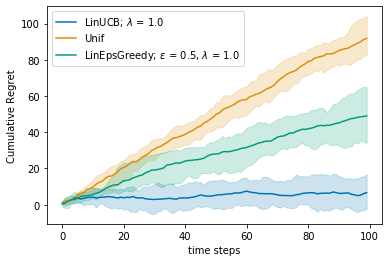

In [12]:

basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(T, d, delta, lambda_reg=1.)
agent2 = LinUniform()
agent3 = LinEpsilonGreedy(T, d, epsilon=.5, lambda_reg=1.)

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3], Nmc=N, T=T)

plot_regret(all_data)

### You should get a straight diagonal line for Unif and a nice, almost flat curve for LinUCB.
(figure generated with the right implementation)

## Discussion: 
`LinUCB` takes as input a parameter lambda_reg that controls the regularisation in the least squares estimation. Choosing it is not easy and to the best of my knowledge there is no clear rule... but maybe we could see experimentally if it impacts the results. Run a few `LinUCB` with different lambda_reg values and plot the results. Beware! You will have to modify the function "name()" of `LinUCB` to include the chosen value, otherwise the plotting function will overwrite each curve (this holds for the next experiments as well).

## Discussion: please comment on your results briefly. Do they validate your hypotheses or not? Why?

> TODO PUTA

# LinUCB with $\alpha$ scaling



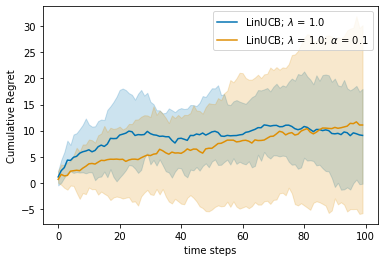

In [13]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(T, d, delta, lambda_reg=1.)
agent2 = LinUCB(T, d, delta, lambda_reg=1., alpha=0.1)
#....TODO

all_data = experiment(basicGaussianBandit, [agent1, agent2], Nmc=10, T=100)

plot_regret(all_data)

## Discussion: please comment on your results briefly. Do they validate your hypotheses or not? Why?

# LinTS versus LinUCB

> TODO PUTA

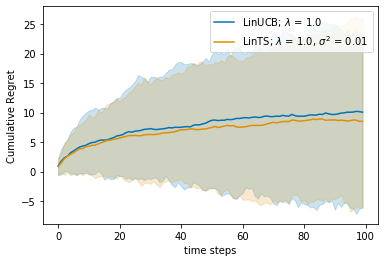

In [15]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(T, d, delta, lambda_reg=1.)
agent2 = LinTS(T, d, lambda_reg=1., sigma=.1)
#....TODO

all_data = experiment(basicGaussianBandit, [agent1, agent2], Nmc=100, T=100)

plot_regret(all_data)

## Discussion: please comment on your results briefly. Do they validate your hypotheses or not? Why?

> TODO PUTA